# Финальный проект модуля Python
#  «Анализ данных об оптовых продажах аудиотехники»

**В финальном проекте модуля Python вам предстоит поработать аналитиком данных в компании «Карпов Саунд», которая занимается оптовой продажей аудиотехники и предлагает широкий ассортимент товаров от ведущих мировых брендов, включающий профессиональные аудиосистемы, домашние кинотеатры, портативные аудиоустройства и прочие аксессуары.** 

«Карпов Саунд» сотрудничает с крупными розничными сетями и специализированными магазинами аудиотехники в России. Клиенты компании регулярно оставляют заявки на закупку товаров в CRM системе, менеджеры связываются с клиентами, обсуждают детали, после чего заказы либо подтверждаются менеджерами, либо по разным причинам отменяются. 

В «Карпов Саунд» трепетно относятся к хранению информации о своих товарах, клиентах и заказах, однако в самый неподходящий момент хранилище данных компании оказалось временно недоступно из-за плановых работ по его оптимизации. Поэтому в рамках этого проекта все данные будут представлены не в самом удобном для анализа виде — в формате резервной выгрузки, разложенной по разным папкам на сервере компании.

Вам необходимо собрать данные из разрозненных источников, проанализировать их и сделать выводы, которые помогут руководству компании принять верные тактические решения.

**В ходе работы над проектом вам встретятся следующие таблицы:**  

1) orders (данные о заказах):  
- order_id — номер заказа  
- product_id — идентификатор товара  
- quantity — количество этого товара в заказе

2) order_status (данные о статусах заказов и клиентах):
- order_id — номер заказа  
- client_id — идентификатор клиента  
- status — статус заказа

3) products (данные о товарах):
- id — идентификатор товара  
- name — имя товара (сначала указан бренд, через запятую модель товара)  
- price — цена единицы товара, в долларах

Каждый заказ имеет статус или подтвержденного (`confirmed`), или отмененного (`canceled`). В одном заказе может быть несколько разных товаров. Если заказ был отменен, а потом создан такой же (тем же клиентом, с теми же товарами, у того же менеджера), в базе останется запись о двух заказах с разными номерами и статусами, поскольку система не позволяет создать заказ с тем же номером.

Сначала вам нужно собрать и предобработать три типа датасетов: `orders.csv`, `order_status.csv`, `products.csv`.

На схеме показано, как связаны таблицы между собой:

![](https://storage.yandexcloud.net/klms-public/production/learning-content/457/4167/37264/104636/497986/er_white.png)

Данные находятся в папке `data` из директории `shared` (`shared` -> `homeworks` -> `python_ds_miniprojects` -> `final_project`). Внутри папки `data` находятся 2 другие папки: `orders` и `products`.

В папке `orders` папки с датами, в которые сделаны записи. В этих папках — папки с именами менеджеров по продажам. Эти папки содержат файлы `orders.csv` и `order_status.csv` (в каждой папке по одной паре файлов). Пример структуры: `data` -> `orders` -> `2024-03-01` -> `Алексей Саксофонов` -> `orders.csv` и `order_status.csv`.

В папке `products` папки с категориями товаров. В этих папках файлы `products.csv` (в каждой папке по одному файлу). Пример структуры: `data` -> `products` -> `AV-процессор` -> `products.csv`.

Кроме того у вас есть файл `usd_rate.txt` с курсом доллара США на каждый день анализируемого периода (данные в формате `дата,курс,валюта`). Он потребуется в середине проекта.

In [1]:
import pandas as pd
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt

### Соберем датасет с заказами по папкам

In [2]:
#для папки products

folder_path = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-vasilisa-tolstaja--7dc33/shared/homeworks/python_ds_miniprojects/final_project/data/products/'

file_paths_products = []
product_types = []

for product_type_folders in os.listdir(folder_path):
    product_type_folders_paths = os.path.join(folder_path, product_type_folders)
    
    product_types.append(product_type_folders)
    
    for files in os.listdir(product_type_folders_paths):
        files_paths = os.path.join(product_type_folders_paths, files)
        
            
    file_paths_products.append(files_paths)
    
print(file_paths_products)
print()
print(product_types)

['/mnt/HC_Volume_18315164/home-jupyter/jupyter-vasilisa-tolstaja--7dc33/shared/homeworks/python_ds_miniprojects/final_project/data/products/AV-ресивер/products.csv', '/mnt/HC_Volume_18315164/home-jupyter/jupyter-vasilisa-tolstaja--7dc33/shared/homeworks/python_ds_miniprojects/final_project/data/products/Настенная акустика/products.csv', '/mnt/HC_Volume_18315164/home-jupyter/jupyter-vasilisa-tolstaja--7dc33/shared/homeworks/python_ds_miniprojects/final_project/data/products/Система караоке/products.csv', '/mnt/HC_Volume_18315164/home-jupyter/jupyter-vasilisa-tolstaja--7dc33/shared/homeworks/python_ds_miniprojects/final_project/data/products/Напольная акустика/products.csv', '/mnt/HC_Volume_18315164/home-jupyter/jupyter-vasilisa-tolstaja--7dc33/shared/homeworks/python_ds_miniprojects/final_project/data/products/Полочная акустика/products.csv', '/mnt/HC_Volume_18315164/home-jupyter/jupyter-vasilisa-tolstaja--7dc33/shared/homeworks/python_ds_miniprojects/final_project/data/products/Сабвуфе

In [3]:
#для папки orders

folder_path = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-vasilisa-tolstaja--7dc33/shared/homeworks/python_ds_miniprojects/final_project/data/orders/'

file_paths_orders = []
file_paths_order_statuses = []


for date in os.listdir(folder_path):
    dates_paths = os.path.join(folder_path, date)
    
    
    for name in os.listdir(dates_paths):
        names_paths = os.path.join(dates_paths, name)
        
    
        for files in os.listdir(names_paths):
            files_paths = os.path.join(names_paths, files)
        
            if files == 'order_status.csv':
                file_paths_order_statuses.append(files_paths)
            elif files == 'orders.csv':
                file_paths_orders.append(files_paths)
        
    
print(f'file_paths_orders:\n\n {file_paths_orders}')
print()
print(f'file_paths_order_statuses:\n\n {file_paths_order_statuses}')
print()
print(f'Длина списка file_paths_orders: {len(file_paths_orders)} и file_paths_order_statuses: {len(file_paths_order_statuses)}')

file_paths_orders:

 ['/mnt/HC_Volume_18315164/home-jupyter/jupyter-vasilisa-tolstaja--7dc33/shared/homeworks/python_ds_miniprojects/final_project/data/orders/2024-03-10/Владимир Ударников/orders.csv', '/mnt/HC_Volume_18315164/home-jupyter/jupyter-vasilisa-tolstaja--7dc33/shared/homeworks/python_ds_miniprojects/final_project/data/orders/2024-03-10/Екатерина Тарелкина/orders.csv', '/mnt/HC_Volume_18315164/home-jupyter/jupyter-vasilisa-tolstaja--7dc33/shared/homeworks/python_ds_miniprojects/final_project/data/orders/2024-03-10/Сергей Контрабасов/orders.csv', '/mnt/HC_Volume_18315164/home-jupyter/jupyter-vasilisa-tolstaja--7dc33/shared/homeworks/python_ds_miniprojects/final_project/data/orders/2024-03-01/Владимир Ударников/orders.csv', '/mnt/HC_Volume_18315164/home-jupyter/jupyter-vasilisa-tolstaja--7dc33/shared/homeworks/python_ds_miniprojects/final_project/data/orders/2024-03-01/Екатерина Тарелкина/orders.csv', '/mnt/HC_Volume_18315164/home-jupyter/jupyter-vasilisa-tolstaja--7dc33/share

In [4]:
pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-vasilisa-tolstaja--7dc33/shared/homeworks/python_ds_miniprojects/final_project/data/orders/2024-03-10/Владимир Ударников/orders.csv')

,order_id,product_id,quantity
0,QPLK-54839036,489,11
1,QPLK-54839036,594,6
2,QPLK-54839036,670,16
3,QPLK-54839036,469,9
4,QPLK-54839036,1302,5
5,QPLK-54839036,1309,5
6,QPLK-54839036,134,4
7,QPLK-54839036,1659,10


In [5]:
df7 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-vasilisa-tolstaja--7dc33/shared/homeworks/python_ds_miniprojects/final_project/data/orders/2024-03-10/Екатерина Тарелкина/orders.csv')
df7 = df7.set_index(['order_id', 'product_id'])
df7

quantity
order_id      product_id          
MAQJ-95867467 317               16
              1565              12
              1039              28
              1613               9
              1354              13
              570               38
              306               14
              495               18
              1392              34
              624               28
              567               42
              751               12

## Шаг 2

**Ваша первая задача — собрать данные со всех папок в три датафрейма:**  
1. `df_orders` — на основе датасетов `orders.csv` + добавьте колонку `manager` с именами менеджеров и колонку `date` с датами. 
2. `df_order_status` — на основе датасетов `order_status.csv`.  
3. `df_products` — на основе датасетов `products.csv` + добавьте колонку `category` с категориями товаров.  

**Соберите датафреймы и сохраните их в соответствующие csv файлы: `df_orders.csv`, `df_order_status.csv` и `df_products.csv`. Отправьте файлы на проверку в LMS.**

In [6]:
#соберем датасет df_orders — на основе датасетов orders.csv

df_orders = pd.DataFrame()
for path in file_paths_orders:
    df = pd.read_csv(path)
    df['manager'] = path.split('/')[-2]
    df['date'] = path.split('/')[-3]
    df_orders = pd.concat([df_orders, df], ignore_index=True)
    
#     df_orders = df_orders.set_index(['date', 'manager', 'order_id', 'product_id'])
    
   
df_orders

,order_id,product_id,quantity,manager,date
0,QPLK-54839036,489,11,Владимир Ударников,2024-03-10
1,QPLK-54839036,594,6,Владимир Ударников,2024-03-10
2,QPLK-54839036,670,16,Владимир Ударников,2024-03-10
3,QPLK-54839036,469,9,Владимир Ударников,2024-03-10
4,QPLK-54839036,1302,5,Владимир Ударников,2024-03-10
...,...,...,...,...,...
4598,UAKD-95751033,812,24,Ксения Балалайкина,2024-03-26
4599,UAKD-95751033,145,9,Ксения Балалайкина,2024-03-26
4600,UAKD-95751033,194,6,Ксения Балалайкина,2024-03-26
4601,UAKD-95751033,1086,3,Ксения Балалайкина,2024-03-26


In [7]:
df_orders.to_csv('df_orders.csv', index=False)

In [8]:
#соберем датасет df_order_status — на основе датасетов order_status.csv

df_order_status = pd.DataFrame()

for path in file_paths_order_statuses:
    df = pd.read_csv(path)
    df_order_status = pd.concat([df_order_status, df], ignore_index=True)
df_order_status

,order_id,client_id,status
0,QPLK-54839036,52,confirmed
1,MAQJ-95867467,84,canceled
2,KHLF-51759445,23,confirmed
3,DALF-47566548,97,confirmed
4,BZHU-92977894,29,canceled
...,...,...,...
341,SOCT-63427141,30,confirmed
342,HLDH-41146746,22,confirmed
343,IZFC-94335845,56,confirmed
344,CUDB-19668701,82,confirmed


In [9]:
df_order_status.to_csv('df_order_status.csv', index=False)

In [10]:
#соберем датасет df_products — на основе датасетов  products.csv

df_products = pd.DataFrame()
for path, product in zip(file_paths_products, product_types):
    df = pd.read_csv(path)
    df['category'] = product
    df_products = pd.concat([df_products, df], ignore_index=True)
    
df_products

,id,name,price,category
0,207,"Denon, AVR-S540BT",243.52,AV-ресивер
1,208,"Denon, AVR-X3700H",1305.52,AV-ресивер
2,209,"Denon, AVR-X4700H",1620.21,AV-ресивер
3,210,"Denon, AVR-X6700H",2050.31,AV-ресивер
4,211,"Denon, AVC-X4700H",1496.81,AV-ресивер
...,...,...,...,...
1672,1592,"Yamaha, YH-L700A",425.72,Беспроводные наушники
1673,1593,"Yamaha, HPH-MT8",267.38,Беспроводные наушники
1674,1594,"Yamaha, TW-E5A",170.30,Беспроводные наушники
1675,1595,"Yamaha, YH-E500A",222.75,Беспроводные наушники


In [11]:
df_products.to_csv('df_products.csv', index=False)

### Посмотрим на общую динамику заказов и определим дни, которые выбиваются из общей картины

## Шаг 3

Посчитайте количество заказов в каждый день. **Определите день с наибольшим числом заказов.** Укажите этот день в том формате, в котором он представлен в данных (гггг-мм-дд).

In [12]:
df_orders

,order_id,product_id,quantity,manager,date
0,QPLK-54839036,489,11,Владимир Ударников,2024-03-10
1,QPLK-54839036,594,6,Владимир Ударников,2024-03-10
2,QPLK-54839036,670,16,Владимир Ударников,2024-03-10
3,QPLK-54839036,469,9,Владимир Ударников,2024-03-10
4,QPLK-54839036,1302,5,Владимир Ударников,2024-03-10
...,...,...,...,...,...
4598,UAKD-95751033,812,24,Ксения Балалайкина,2024-03-26
4599,UAKD-95751033,145,9,Ксения Балалайкина,2024-03-26
4600,UAKD-95751033,194,6,Ксения Балалайкина,2024-03-26
4601,UAKD-95751033,1086,3,Ксения Балалайкина,2024-03-26


In [13]:
amount_of_orders = df_orders.groupby(['date', 'order_id']) \
    .agg({'order_id': 'count'}) \
    .rename(columns={'order_id': 'amount_of_orders'}) \
    .groupby('date').agg({'amount_of_orders': 'sum'}) \
    .sort_values('amount_of_orders', ascending=False)

amount_of_orders.head(1)


,amount_of_orders
date,
2024-03-14,437


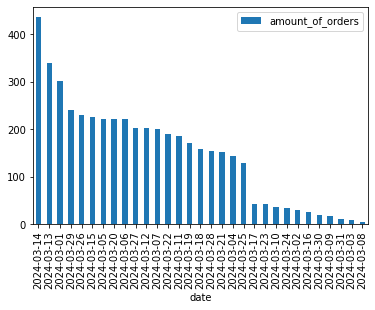

In [14]:
amount_of_orders.plot(kind='bar');

## Шаг 4

**Постройте график с количеством заказов по дням и определите, заметна ли в данных сезонность.**

- Да, по выходным заказов намного больше, чем в остальные дни  
- Да, по выходным почти нет заказов  
- Да, по понедельникам заказов всегда больше, чем в остальные дни недели  
- Да, по понедельникам заказов всегда меньше, чем в остальные дни недели  
- Нет, в данных сложно обнаружить какие-то закономерности  

In [15]:
amount_of_orders_by_date = amount_of_orders.reset_index()
amount_of_orders_by_date['date'] = pd.to_datetime(amount_of_orders_by_date['date'])
amount_of_orders_by_date['week_day'] = amount_of_orders_by_date.date.dt.day_name()
amount_of_orders_by_date = amount_of_orders_by_date.drop('date', axis=1)
amount_of_orders_by_date = amount_of_orders_by_date.groupby('week_day', as_index=False) \
    .agg({'amount_of_orders': 'sum'}) \
    .sort_values('amount_of_orders', ascending=False)
amount_of_orders_by_date

,week_day,amount_of_orders
6,Wednesday,985
0,Friday,964
4,Thursday,945
5,Tuesday,828
1,Monday,616
2,Saturday,136
3,Sunday,129


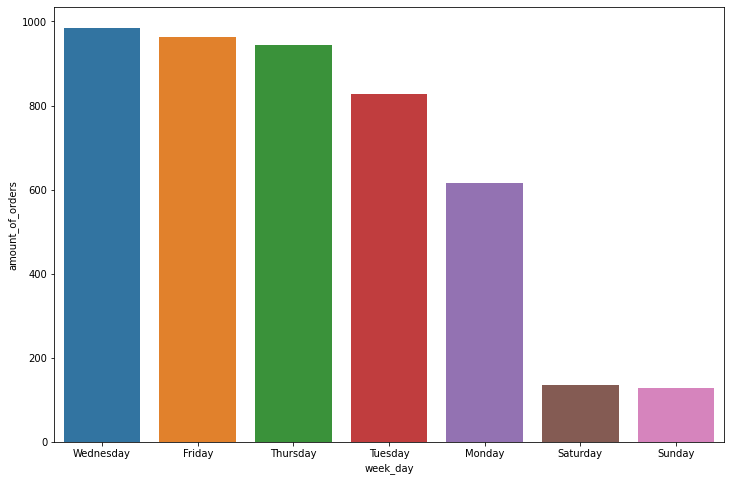

In [16]:
plt.figure(figsize=(12, 8))
sns.barplot(x='week_day', y='amount_of_orders', data=amount_of_orders_by_date);

## Шаг 5

**Кажется, в данных помимо дня с наибольшим числом заказов есть еще один день, который выбивается из общей картины.** Что это за день:  
- Это воскресенье, в которое было много заказов?  
- Это понедельник, в который было много заказов?  
- Это пятница, в которую было мало заказов?  
- Это праздничный день, в который было мало заказов?

Подумайте, почему так вышло? Укажите этот день в том формате, в котором он представлен в данных (гггг-мм-дд)

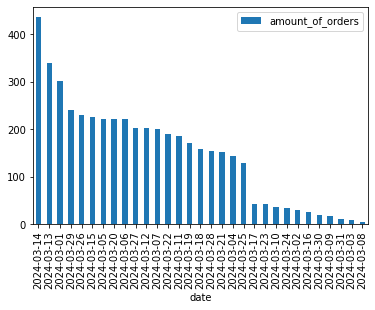

In [17]:
amount_of_orders.plot(kind='bar');

In [18]:
amount_of_orders.loc[amount_of_orders['amount_of_orders'] == amount_of_orders['amount_of_orders'].min()]

,amount_of_orders
date,
2024-03-08,5


## Шаг 6

К вам пришел радостный руководитель отдела продаж и попросил выяснить причину, почему заказы в один из дней резко подскочили, чтобы и дальше увеличивать продажи.

Возможно, в день с наибольшим числом заказов (который вы определили на третьем шаге) отдел маркетинга запустил какую-то акцию? Или менеджеры стали активнее предлагать компаниям оформить заказ? Нужно подробнее изучить этот день. Начнем со статусов заказа.

In [19]:
orders_status = df_orders.merge(df_order_status, on='order_id')
orders_status

,order_id,product_id,quantity,manager,date,client_id,status
0,QPLK-54839036,489,11,Владимир Ударников,2024-03-10,52,confirmed
1,QPLK-54839036,594,6,Владимир Ударников,2024-03-10,52,confirmed
2,QPLK-54839036,670,16,Владимир Ударников,2024-03-10,52,confirmed
3,QPLK-54839036,469,9,Владимир Ударников,2024-03-10,52,confirmed
4,QPLK-54839036,1302,5,Владимир Ударников,2024-03-10,52,confirmed
...,...,...,...,...,...,...,...
4598,UAKD-95751033,812,24,Ксения Балалайкина,2024-03-26,61,confirmed
4599,UAKD-95751033,145,9,Ксения Балалайкина,2024-03-26,61,confirmed
4600,UAKD-95751033,194,6,Ксения Балалайкина,2024-03-26,61,confirmed
4601,UAKD-95751033,1086,3,Ксения Балалайкина,2024-03-26,61,confirmed


In [20]:
orders_status.to_csv('orders_status.csv', index=False)

## Шаг 7

Посмотрите на количество и соотношение подтвержденных и отмененных заказов. **В ответе укажите долю отмененных заказов.** Ответ округлите до двух знаков после точки.

In [21]:
status_df = orders_status.drop_duplicates(subset=['order_id', 'status'])
status_df = status_df.groupby('status') \
    .agg({'status': 'count'}) \
    .rename(columns={'status': 'amount_of_orderes'})
status_df['persentage'] = status_df['amount_of_orderes'] / status_df['amount_of_orderes'].sum(axis=0)
status_df['persentage'] = round(status_df['persentage'], 2)
status_df

,amount_of_orderes,persentage
status,,
canceled,37,0.11
confirmed,309,0.89


## Шаг 8

**Посчитайте количество подтвержденных и отмененных заказов на каждую дату.** Определите, в какой день не было ни одного подтвержденного заказа. Для этого сделайте сводную таблицу, где в строках будут даты, в колонках — стутасы заказов, а значения — число заказов с этим статусом в определенную дату. Пропуски заполните нулями.  

**В ответ укажите день, когда не было ни одного подтвержденного заказа.** Дату укажите в том формате, в котором она представлена в данных (гггг-мм-дд).

In [22]:
status_df_dates = orders_status.groupby(['date', 'status']) \
    .agg({'status': 'count'}) \
    .rename(columns={'status': 'amount_of_orders'})
status_df_dates

amount_of_orders
date       status                     
2024-03-01 canceled                 29
           confirmed               273
2024-03-02 confirmed                30
2024-03-03 confirmed                 8
2024-03-04 confirmed               143
2024-03-05 confirmed               222
2024-03-06 canceled                 12
           confirmed               209
2024-03-07 canceled                  5
           confirmed               196
2024-03-08 confirmed                 5
2024-03-09 canceled                 18
2024-03-10 canceled                 12
           confirmed                23
2024-03-11 canceled                 17
           confirmed               168
2024-03-12 canceled                 31
           confirmed               172
2024-03-13 canceled                263
           confirmed                76
2024-03-14 confirmed               437
2024-03-15 canceled                 16
           confirmed               209
2024-03-16 confirmed                26
2024-03-17 confirmed                43
2024-03-18 confirmed               159
2024-03-19 canceled                 22
           confirmed               150
2024-03-20 canceled                 37
           confirmed               185
2024-03-21 canceled                 31
           confirmed               121
2024-03-22 confirmed               191
2024-03-23 confirmed                42
2024-03-24 confirmed                33
2024-03-25 canceled                 13
           confirmed               116
2024-03-26 canceled                 14
           confirmed               217
2024-03-27 confirmed               203
2024-03-28 confirmed               155
2024-03-29 confirmed               241
2024-03-30 confirmed                20
2024-03-31 confirmed                10

In [23]:
status_df_dates_no_index = status_df_dates.reset_index()
status_df_dates_no_index

,date,status,amount_of_orders
0,2024-03-01,canceled,29
1,2024-03-01,confirmed,273
2,2024-03-02,confirmed,30
3,2024-03-03,confirmed,8
4,2024-03-04,confirmed,143
5,2024-03-05,confirmed,222
6,2024-03-06,canceled,12
7,2024-03-06,confirmed,209
8,2024-03-07,canceled,5
9,2024-03-07,confirmed,196


In [24]:
status_df_dates_pivot = status_df_dates_no_index.pivot(index='status', columns='date', values='amount_of_orders')
status_df_dates_pivot = status_df_dates_pivot.fillna(0)
status_df_dates_pivot

date,2024-03-01,2024-03-02,2024-03-03,2024-03-04,2024-03-05,2024-03-06,2024-03-07,2024-03-08,2024-03-09,2024-03-10,...,2024-03-22,2024-03-23,2024-03-24,2024-03-25,2024-03-26,2024-03-27,2024-03-28,2024-03-29,2024-03-30,2024-03-31
status,,,,,,,,,,,,,,,,,,,,,
canceled,29.0,0.0,0.0,0.0,0.0,12.0,5.0,0.0,18.0,12.0,...,0.0,0.0,0.0,13.0,14.0,0.0,0.0,0.0,0.0,0.0
confirmed,273.0,30.0,8.0,143.0,222.0,209.0,196.0,5.0,0.0,23.0,...,191.0,42.0,33.0,116.0,217.0,203.0,155.0,241.0,20.0,10.0


In [25]:
# ни одного подтвержденного заказа не было 2024-03-09

zero_confirmed_dates = status_df_dates_pivot.loc['confirmed'] == 0
zero_confirmed_dates.index[zero_confirmed_dates].to_list()

['2024-03-09']

## Шаг 9

**Постройте график с заказами по дням в разбивке по статусу заказа.** Посмотрим подробнее на день с наибольшим числом заказов (вместе и подтвержденных, и отменных), который мы определили ранее, и на день, предшествующий ему. Какой вывод можно сделать? Выберите один или несколько вариантов:

- В день с наибольшим числом заказов было очень много отмен  
- В день с наибольшим числом заказов было много успешно оформленных заказов  
- В день, предшествующий дню с наибольшим числом заказов, было много отмен  
- В день, предшествующий дню с наибольшим числом заказов, было много успешно оформленных заказов  
- В день, предшествующий дню с наибольшим числом заказов, не было ни одного успешно оформленного заказа  
- В день, предшествующий дню с наибольшим числом заказов, не было ни одного отмененного заказа

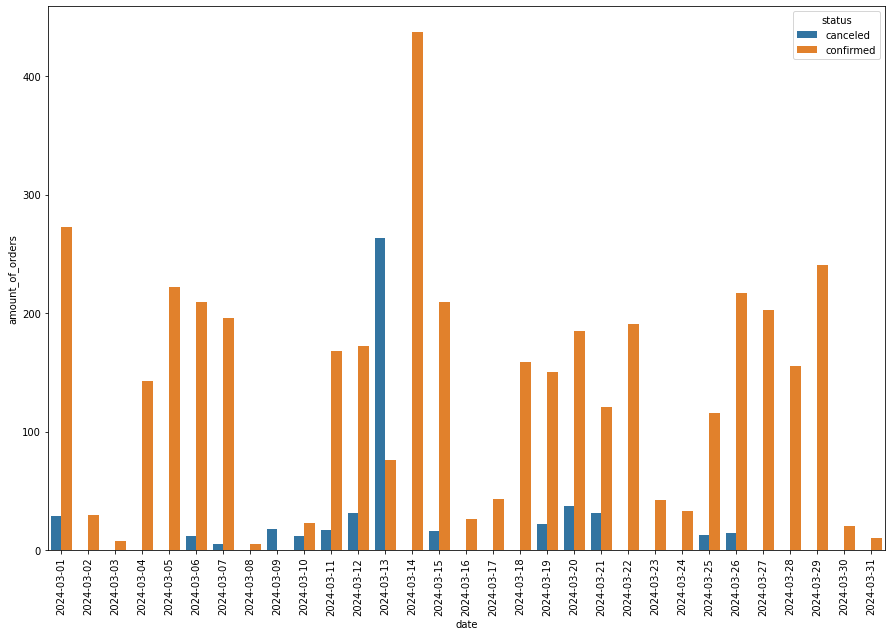

In [26]:
plt.figure(figsize=(15, 10))
sns.barplot(data=status_df_dates_no_index, x='date', y='amount_of_orders', hue='status');
plt.xticks(rotation=90);
plt.show()

## Шаг 10

Рассмотрим эти два дня отдельно (день с наибольшим числом заказов, который мы определили ранее, и день, предшествующий ему). Проанализируйте заказы за эти дни и ответьте, какую из этих гипотез можно назвать наиболее правдоподобной.

- Так сложилось, что один день оказался крайне неудачным для отдела продаж, все клиенты отменили свои заказы. А на следующий день отдел продаж пытался компенсировать отсутствие продаж в предыдущий и перевыполнил дневной план. Почти все заказы не повторяют вчерашние  
- Произошел сбой в работе CRM системы, который не позволил клиентам подтвердить заказ. В результате все созданные в первый день заказы автоматически отменились, поэтому клиентам пришлось оформлять их повторно на следующий день. Почти половина заказов повторяет вчерашние

Как можно определить, что заказ повторяет вчерашний? У заказов будут совпадать сразу несколько параметров: клиент, менеджер, количество уникальных товаров в заказе и общее число товаров в штуках. Но номера заказов будут разными.

In [28]:
status_df_dates_no_index

,date,status,amount_of_orders
0,2024-03-01,canceled,29
1,2024-03-01,confirmed,273
2,2024-03-02,confirmed,30
3,2024-03-03,confirmed,8
4,2024-03-04,confirmed,143
5,2024-03-05,confirmed,222
6,2024-03-06,canceled,12
7,2024-03-06,confirmed,209
8,2024-03-07,canceled,5
9,2024-03-07,confirmed,196


In [29]:
our_date_1 = orders_status.loc[(orders_status['date'] == '2024-03-14')]
our_date_1

,order_id,product_id,quantity,manager,date,client_id,status
1604,IMND-92004620,1634,20,Владимир Ударников,2024-03-14,38,confirmed
1605,IMND-92004620,259,9,Владимир Ударников,2024-03-14,38,confirmed
1606,IMND-92004620,812,24,Владимир Ударников,2024-03-14,38,confirmed
1607,IMND-92004620,652,10,Владимир Ударников,2024-03-14,38,confirmed
1608,IMND-92004620,516,8,Владимир Ударников,2024-03-14,38,confirmed
...,...,...,...,...,...,...,...
2036,JDDH-90010417,1667,44,Ксения Балалайкина,2024-03-14,67,confirmed
2037,JDDH-90010417,1607,4,Ксения Балалайкина,2024-03-14,67,confirmed
2038,JDDH-90010417,644,34,Ксения Балалайкина,2024-03-14,67,confirmed
2039,JDDH-90010417,65,15,Ксения Балалайкина,2024-03-14,67,confirmed


In [30]:
our_date_1.groupby(['date', 'status', 'manager', 'client_id']) \
    .agg({'product_id': 'unique'}) \
    .sort_values('client_id', ascending=False)


product_id
date       status    manager               client_id                                                   
2024-03-14 confirmed Виктор Тромбонов      95         [1459, 557, 988, 483, 673, 49, 1561, 648, 1128...
                     Анастасия Дудкина     94         [1337, 1173, 638, 1416, 1591, 550, 492, 448, 1...
                     Виктор Тромбонов      94         [593, 1598, 423, 180, 1652, 494, 361, 468, 463...
                     Сергей Контрабасов    93         [445, 420, 635, 974, 476, 804, 869, 756, 525, ...
                     Виктор Тромбонов      93         [62, 1140, 582, 499, 1516, 790, 438, 1525, 672...
                     Максим Барабанов      87         [462, 423, 1544, 530, 1203, 1633, 1158, 1636, ...
                     Екатерина Тарелкина   83         [403, 1158, 891, 138, 640, 531, 1586, 583, 619...
                     Маргарита Камертонова 76         [707, 54, 1359, 1545, 667, 1421, 540, 762, 157...
                     Ксения Балалайкина    75         [790, 550, 1646, 1442, 1500, 569, 1128, 304, 5...
                                           73         [494, 1541, 756, 891, 487, 1543, 1193, 512, 12...
                     Маргарита Камертонова 68         [493, 1383, 553, 611, 765, 1056, 435, 1467, 10...
                     Екатерина Тарелкина   68         [1309, 1225, 1248, 448, 1445, 635, 567, 1136, ...
                     Ксения Балалайкина    67         [414, 29, 632, 821, 492, 602, 1431, 240, 342, ...
                     Алексей Саксофонов    66         [1405, 1659, 329, 821, 474, 566, 900, 789, 315...
                     Виктор Тромбонов      60         [291, 786, 984, 1337, 531, 57, 505, 1399, 1603...
                     Екатерина Тарелкина   56         [1249, 1609, 1416, 233, 1054, 487, 624, 1459, ...
                     Маргарита Камертонова 56         [372, 1633, 1357, 452, 628, 875, 1158, 1029, 1...
                     Надежда Гармошкина    53             [555, 1387, 1128, 1590, 1256, 1631, 561, 893]
                     Максим Барабанов      53                 [630, 1648, 1247, 91, 985, 461, 592, 817]
                     Алексей Саксофонов    51         [1319, 1605, 881, 418, 564, 714, 777, 579, 433...
                     Виктор Тромбонов      43            [359, 568, 403, 1293, 57, 1524, 145, 92, 1650]
                     Алексей Саксофонов    43         [511, 240, 583, 468, 648, 763, 17, 1548, 1315,...
                     Анастасия Дудкина     39         [643, 1667, 1497, 477, 1657, 1007, 1457, 855, 30]
                     Владимир Ударников    38         [1634, 259, 812, 652, 516, 644, 557, 588, 1502...
                     Маргарита Камертонова 30         [594, 788, 1369, 617, 904, 808, 473, 53, 452, ...
                                           26         [841, 817, 1621, 1644, 336, 1553, 387, 96, 103...
                     Алексей Саксофонов    25         [17, 1586, 1189, 1248, 1599, 561, 607, 1668, 1...
                                           24                 [509, 250, 979, 714, 534, 1646, 646, 477]
                     Виктор Тромбонов      18                              [1493, 546, 1023, 919, 1320]
                     Маргарита Камертонова 18         [762, 1598, 1099, 1334, 652, 672, 540, 1592, 606]
                     Алексей Саксофонов    17         [1389, 758, 363, 1304, 876, 236, 776, 17, 1393...
                     Надежда Гармошкина    11         [1629, 11, 21, 1222, 456, 1532, 985, 624, 940,...
                     Ксения Балалайкина    7                                     [898, 1401, 658, 1255]

In [31]:
our_date_2 = orders_status.loc[(orders_status['date'] == '2024-03-13') & (orders_status['status'] == 'canceled')]
print(f'Длина датафрейма с отменами: {len(our_date_2)}')
our_date_2

Длина датафрейма с отменами: 263


,order_id,product_id,quantity,manager,date,client_id,status
3186,NENO-68279828,1634,20,Владимир Ударников,2024-03-13,38,canceled
3187,NENO-68279828,259,9,Владимир Ударников,2024-03-13,38,canceled
3188,NENO-68279828,812,24,Владимир Ударников,2024-03-13,38,canceled
3189,NENO-68279828,652,10,Владимир Ударников,2024-03-13,38,canceled
3190,NENO-68279828,516,8,Владимир Ударников,2024-03-13,38,canceled
...,...,...,...,...,...,...,...
3520,BBFJ-27674101,447,18,Ксения Балалайкина,2024-03-13,73,canceled
3521,GHGB-88045656,898,10,Ксения Балалайкина,2024-03-13,7,canceled
3522,GHGB-88045656,1401,12,Ксения Балалайкина,2024-03-13,7,canceled
3523,GHGB-88045656,658,12,Ксения Балалайкина,2024-03-13,7,canceled


In [32]:
our_date_2.groupby(['date', 'status', 'manager', 'client_id']) \
    .agg({'product_id': 'unique'}) \
    .sort_values('client_id', ascending=False)

product_id
date       status   manager               client_id                                                   
2024-03-13 canceled Виктор Тромбонов      95         [1459, 557, 988, 483, 673, 49, 1561, 648, 1128...
                                          94         [593, 1598, 423, 180, 1652, 494, 361, 468, 463...
                                          93         [62, 1140, 582, 499, 1516, 790, 438, 1525, 672...
                    Екатерина Тарелкина   83         [403, 1158, 891, 138, 640, 531, 1586, 583, 619...
                    Маргарита Камертонова 77              [1062, 750, 1262, 361, 1633, 498, 1065, 143]
                                          76         [707, 54, 1359, 1545, 667, 1421, 540, 762, 157...
                    Ксения Балалайкина    75         [790, 550, 1646, 1442, 1500, 569, 1128, 304, 5...
                                          73         [494, 1541, 756, 891, 487, 1543, 1193, 512, 12...
                    Маргарита Камертонова 68         [493, 1383, 553, 611, 765, 1056, 435, 1467, 10...
                    Алексей Саксофонов    66         [1405, 1659, 329, 821, 474, 566, 900, 789, 315...
                    Виктор Тромбонов      60         [291, 786, 984, 1337, 531, 57, 505, 1399, 1603...
                    Маргарита Камертонова 59         [540, 557, 941, 269, 643, 889, 644, 578, 1638,...
                    Екатерина Тарелкина   56         [1249, 1609, 1416, 233, 1054, 487, 624, 1459, ...
                    Алексей Саксофонов    51         [1319, 1605, 881, 418, 564, 714, 777, 579, 433...
                                          43         [511, 240, 583, 468, 648, 763, 17, 1548, 1315,...
                    Владимир Ударников    38         [1634, 259, 812, 652, 516, 644, 557, 588, 1502...
                    Маргарита Камертонова 26         [841, 817, 1621, 1644, 336, 1553, 387, 96, 103...
                    Максим Барабанов      23         [1476, 650, 1369, 1465, 134, 877, 788, 15, 755...
                    Ксения Балалайкина    7                                     [898, 1401, 658, 1255]

In [33]:
dif_df = our_date_2.merge(our_date_1, on=['product_id', 'quantity', 'manager', 'client_id'])
print(f'Процент идентичных заказов в эти дни (т.е. переофорленных отмененных заказов): {len(dif_df) / len(our_date_2) * 100}')
dif_df

Процент идентичных заказов в эти дни (т.е. переофорленных отмененных заказов): 84.79087452471484


,order_id_x,product_id,quantity,manager,date_x,client_id,status_x,order_id_y,date_y,status_y
0,NENO-68279828,1634,20,Владимир Ударников,2024-03-13,38,canceled,IMND-92004620,2024-03-14,confirmed
1,NENO-68279828,259,9,Владимир Ударников,2024-03-13,38,canceled,IMND-92004620,2024-03-14,confirmed
2,NENO-68279828,812,24,Владимир Ударников,2024-03-13,38,canceled,IMND-92004620,2024-03-14,confirmed
3,NENO-68279828,652,10,Владимир Ударников,2024-03-13,38,canceled,IMND-92004620,2024-03-14,confirmed
4,NENO-68279828,516,8,Владимир Ударников,2024-03-13,38,canceled,IMND-92004620,2024-03-14,confirmed
...,...,...,...,...,...,...,...,...,...,...
218,BBFJ-27674101,447,18,Ксения Балалайкина,2024-03-13,73,canceled,UETB-44283966,2024-03-14,confirmed
219,GHGB-88045656,898,10,Ксения Балалайкина,2024-03-13,7,canceled,JUGG-73806170,2024-03-14,confirmed
220,GHGB-88045656,1401,12,Ксения Балалайкина,2024-03-13,7,canceled,JUGG-73806170,2024-03-14,confirmed
221,GHGB-88045656,658,12,Ксения Балалайкина,2024-03-13,7,canceled,JUGG-73806170,2024-03-14,confirmed


### Посчитаем ключевые метрики, посмотрим на их динамику и составим небольшой отчет

## Шаг 11

**У вас есть данные за целый месяц, поэтому пора посчитать ключевые метрики этого месяца.** Но вот незадача - в ваших данных цена единицы товара указана в долларах США, потому что закупаете их в долларах, но продаете товары за российские рубли (по тому курсу, который установил Центробанк на дату продажи), а значит и метрики требуется посчитать в рублях. Хорошо, что у вас есть текстовый файл с курсом доллара США на каждую дату. **Откройте файл `usd_rate.txt`, соберите из него датафрейм с 2 колонками: `date` и `currency_rate`. Посчитайте среднее значение курса доллара за месяц.** Результат округлите до двух знаков после точки.

In [34]:
path = ('usd_rate.txt')

strochka = []

dates = []
values = []



data = open(path).readlines()
for i in data:
   strochka.append(i.split(','))
for i in strochka:
    dates.append(i[0])
    values.append(i[1])

        
print(f'Даты: {dates}')
print()
print(f'Значения: {values}')

usd_df = pd.DataFrame({'date': dates, 'currency_rate': values})
usd_df

Даты: ['2024-03-01', '2024-03-02', '2024-03-03', '2024-03-04', '2024-03-05', '2024-03-06', '2024-03-07', '2024-03-08', '2024-03-09', '2024-03-10', '2024-03-11', '2024-03-12', '2024-03-13', '2024-03-14', '2024-03-15', '2024-03-16', '2024-03-17', '2024-03-18', '2024-03-19', '2024-03-20', '2024-03-21', '2024-03-22', '2024-03-23', '2024-03-24', '2024-03-25', '2024-03-26', '2024-03-27', '2024-03-28', '2024-03-29', '2024-03-30', '2024-03-31']

Значения: ['90.8423', '91.3336', '91.3336', '91.3336', '91.3534', '91.1604', '90.3412', '90.7493', '90.7493', '90.7493', '90.7493', '90.6252', '90.8818', '91.5449', '91.6359', '91.87', '91.87', '91.87', '91.9829', '92.2243', '92.6861', '91.9499', '92.6118', '92.6118', '92.6118', '92.7761', '92.5745', '92.5919', '92.2628', '92.366', '92.366']


,date,currency_rate
0,2024-03-01,90.8423
1,2024-03-02,91.3336
2,2024-03-03,91.3336
3,2024-03-04,91.3336
4,2024-03-05,91.3534
5,2024-03-06,91.1604
6,2024-03-07,90.3412
7,2024-03-08,90.7493
8,2024-03-09,90.7493
9,2024-03-10,90.7493


In [35]:
#поменяем типы данных в датафрейме
usd_df['date'] = pd.to_datetime(usd_df['date'])
usd_df['currency_rate'] = usd_df['currency_rate'].astype('float')
usd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           31 non-null     datetime64[ns]
 1   currency_rate  31 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 624.0 bytes


In [36]:
#среднее значение для курса доллара за месяц
a = round(usd_df.currency_rate.mean(), 2)
print(f'Среднее значение курса доллара за месяц: {a}')

Среднее значение курса доллара за месяц: 91.7


## Шаг 12

**Работу с ключевыми метриками начните с подсчета общей выручки.** Данные по товарам в подтвержденных заказах у вас есть в датафрейме `orders_status`, а стоимость одной единицы товара можно взять из датафрейма `df_products`. Объедините эти датафреймы в общий `df_full`, добавьте к ним информацию по курсу доллара на каждую дату. Создайте колонку с выручкой для каждого товара в заказах и посчитайте, **чему равна общая выручка в рублях?** Учитывайте только подтвержденные заказы. Результат округлите до двух знаков после точки.

In [37]:
orders_status

,order_id,product_id,quantity,manager,date,client_id,status
0,QPLK-54839036,489,11,Владимир Ударников,2024-03-10,52,confirmed
1,QPLK-54839036,594,6,Владимир Ударников,2024-03-10,52,confirmed
2,QPLK-54839036,670,16,Владимир Ударников,2024-03-10,52,confirmed
3,QPLK-54839036,469,9,Владимир Ударников,2024-03-10,52,confirmed
4,QPLK-54839036,1302,5,Владимир Ударников,2024-03-10,52,confirmed
...,...,...,...,...,...,...,...
4598,UAKD-95751033,812,24,Ксения Балалайкина,2024-03-26,61,confirmed
4599,UAKD-95751033,145,9,Ксения Балалайкина,2024-03-26,61,confirmed
4600,UAKD-95751033,194,6,Ксения Балалайкина,2024-03-26,61,confirmed
4601,UAKD-95751033,1086,3,Ксения Балалайкина,2024-03-26,61,confirmed


In [38]:
df_products

,id,name,price,category
0,207,"Denon, AVR-S540BT",243.52,AV-ресивер
1,208,"Denon, AVR-X3700H",1305.52,AV-ресивер
2,209,"Denon, AVR-X4700H",1620.21,AV-ресивер
3,210,"Denon, AVR-X6700H",2050.31,AV-ресивер
4,211,"Denon, AVC-X4700H",1496.81,AV-ресивер
...,...,...,...,...
1672,1592,"Yamaha, YH-L700A",425.72,Беспроводные наушники
1673,1593,"Yamaha, HPH-MT8",267.38,Беспроводные наушники
1674,1594,"Yamaha, TW-E5A",170.30,Беспроводные наушники
1675,1595,"Yamaha, YH-E500A",222.75,Беспроводные наушники


In [39]:
usd_df

,date,currency_rate
0,2024-03-01,90.8423
1,2024-03-02,91.3336
2,2024-03-03,91.3336
3,2024-03-04,91.3336
4,2024-03-05,91.3534
5,2024-03-06,91.1604
6,2024-03-07,90.3412
7,2024-03-08,90.7493
8,2024-03-09,90.7493
9,2024-03-10,90.7493


In [40]:
df_full = orders_status.merge(df_products, left_on='product_id', right_on='id')
df_full['date'] = pd.to_datetime(df_full['date'])
df_full

,order_id,product_id,quantity,manager,date,client_id,status,id,name,price,category
0,QPLK-54839036,489,11,Владимир Ударников,2024-03-10,52,confirmed,489,"Heco, Ambient 33F",290.74,Настенная акустика
1,YQDE-00869611,489,10,Алексей Саксофонов,2024-03-12,20,confirmed,489,"Heco, Ambient 33F",290.74,Настенная акустика
2,KBOO-97036112,489,18,Алексей Саксофонов,2024-03-19,24,confirmed,489,"Heco, Ambient 33F",290.74,Настенная акустика
3,QPLK-54839036,594,6,Владимир Ударников,2024-03-10,52,confirmed,594,"JBL, Control 28-1",301.85,Настенная акустика
4,PZUZ-70017989,594,18,Надежда Гармошкина,2024-03-01,33,confirmed,594,"JBL, Control 28-1",301.85,Настенная акустика
...,...,...,...,...,...,...,...,...,...,...,...
4598,EQIU-00464768,335,9,Виктор Тромбонов,2024-03-26,30,confirmed,335,"Electrohome, Karaoke Machine",176.59,Система караоке
4599,EQIU-00464768,822,7,Виктор Тромбонов,2024-03-26,30,confirmed,822,"LG, LHD457",172.20,Домашний кинотеатр
4600,IZFC-94335845,1568,38,Максим Барабанов,2024-03-26,56,confirmed,1568,"Xiaomi, Mi Smart Display",83.56,Умная колонка
4601,CUDB-19668701,1333,22,Маргарита Камертонова,2024-03-26,82,confirmed,1333,"Sennheiser, HD 450BT",129.99,Беспроводные наушники


In [41]:
df_full = df_full.merge(usd_df, on='date')
df_full

,order_id,product_id,quantity,manager,date,client_id,status,id,name,price,category,currency_rate
0,QPLK-54839036,489,11,Владимир Ударников,2024-03-10,52,confirmed,489,"Heco, Ambient 33F",290.74,Настенная акустика,90.7493
1,QPLK-54839036,594,6,Владимир Ударников,2024-03-10,52,confirmed,594,"JBL, Control 28-1",301.85,Настенная акустика,90.7493
2,QPLK-54839036,670,16,Владимир Ударников,2024-03-10,52,confirmed,670,"KEF, LSX Wireless",810.17,Беспроводная акустика,90.7493
3,QPLK-54839036,469,9,Владимир Ударников,2024-03-10,52,confirmed,469,"Heco, Studio Pro 10",82.34,Конденсаторный микрофон,90.7493
4,QPLK-54839036,1302,5,Владимир Ударников,2024-03-10,52,confirmed,1302,"Rode, NT1-A",191.86,Конденсаторный микрофон,90.7493
...,...,...,...,...,...,...,...,...,...,...,...,...
4598,YHMP-64962628,564,40,Маргарита Камертонова,2024-03-03,44,confirmed,564,"JBL, Tune 510BT",45.38,Беспроводные наушники,91.3336
4599,YHMP-64962628,486,17,Маргарита Камертонова,2024-03-03,44,confirmed,486,"Heco, Ambient 22F",185.50,Настенная акустика,91.3336
4600,YHMP-64962628,832,28,Маргарита Камертонова,2024-03-03,44,confirmed,832,"LG, SK1",86.56,Саундбар,91.3336
4601,YHMP-64962628,254,10,Маргарита Камертонова,2024-03-03,44,confirmed,254,"Edifier, R1280T",86.99,Активные колонки,91.3336


In [42]:
#добавим колонку с выручкой для подтвержденных заказов
df_full['price_rub'] = df_full['price'] * df_full['currency_rate']
# df_full['price_rub'] = df_full['price_rub'].round(2)


df_full['revenue_rub'] = df_full['price_rub'] * df_full['quantity']
# df_full['revenue_rub'] = df_full['revenue_rub'].round(2)

df_confirmed = df_full.query("status == 'confirmed'")
a = df_confirmed.revenue_rub.sum()
print(f'Общая выручка в рублях составила: {a.round(2)}')

df_full

Общая выручка в рублях составила: 2038231821.56


,order_id,product_id,quantity,manager,date,client_id,status,id,name,price,category,currency_rate,price_rub,revenue_rub
0,QPLK-54839036,489,11,Владимир Ударников,2024-03-10,52,confirmed,489,"Heco, Ambient 33F",290.74,Настенная акустика,90.7493,26384.451482,2.902290e+05
1,QPLK-54839036,594,6,Владимир Ударников,2024-03-10,52,confirmed,594,"JBL, Control 28-1",301.85,Настенная акустика,90.7493,27392.676205,1.643561e+05
2,QPLK-54839036,670,16,Владимир Ударников,2024-03-10,52,confirmed,670,"KEF, LSX Wireless",810.17,Беспроводная акустика,90.7493,73522.360381,1.176358e+06
3,QPLK-54839036,469,9,Владимир Ударников,2024-03-10,52,confirmed,469,"Heco, Studio Pro 10",82.34,Конденсаторный микрофон,90.7493,7472.297362,6.725068e+04
4,QPLK-54839036,1302,5,Владимир Ударников,2024-03-10,52,confirmed,1302,"Rode, NT1-A",191.86,Конденсаторный микрофон,90.7493,17411.160698,8.705580e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4598,YHMP-64962628,564,40,Маргарита Камертонова,2024-03-03,44,confirmed,564,"JBL, Tune 510BT",45.38,Беспроводные наушники,91.3336,4144.718768,1.657888e+05
4599,YHMP-64962628,486,17,Маргарита Камертонова,2024-03-03,44,confirmed,486,"Heco, Ambient 22F",185.50,Настенная акустика,91.3336,16942.382800,2.880205e+05
4600,YHMP-64962628,832,28,Маргарита Камертонова,2024-03-03,44,confirmed,832,"LG, SK1",86.56,Саундбар,91.3336,7905.836416,2.213634e+05
4601,YHMP-64962628,254,10,Маргарита Камертонова,2024-03-03,44,confirmed,254,"Edifier, R1280T",86.99,Активные колонки,91.3336,7945.109864,7.945110e+04


## Шаг 13

**Следующая метрика, которую вам нужно посчитать — средний чек в этом месяце (в рублях).** Разделите общую выручку на количество заказов. Результат округлите до двух знаков после точки.

In [43]:

mean_revenue = df_confirmed.revenue_rub.sum() / df_confirmed.order_id.nunique()
mean_revenue.round(2)


6596219.49

## Шаг 14

Ключевые метрики месяца вы посчитали, теперь попробуйте посмотреть на их динамику внутри месяца: посчитайте выручку, средний чек и число заказов — на каждый день. Посмотрите на графики и выберите верные ответы:

- число заказов и выручка каждый день изменяются в одинаковом направлении (если в этот день число заказов выросло, то и выручка выросла; число заказов упало — в этот же день упала и выручка)  
- число заказов и выручка не каждый день изменяются в одинаковом направлении (если в какой-то день число заказов выросло, то выручка может упасть, и наоборот: число заказов упало — в этот же день выручка выросла)  
- средний чек и выручка каждый день изменяются в одинаковом направлении (если в этот день средний чек вырос, то и выручка выросла; средний чек упал — в этот же день упала и выручка)  
- средний чек и выручка не каждый день изменяются в одинаковом направлении (если в какой-то день средний чек вырос, то выручка может упасть, и наоборот: средний чек упал — в этот же день выручка выросла)  
- в день с наибольшим числом заказов и выручка, и средний чек также показывают максимальное значение  
- в день с наибольшим числом заказов выручка и/или средний чек не показывают максимальное значение  
- с течением времени выручка то увеличивается, то уменьшается  
- с течением времени выручка только увеличивается  
- на протяжении всего месяца средний чек то увеличивается, то уменьшается  
- средний чек на протяжении всего месяца имеет одинаковое значение

In [44]:
# посчитаем выручку, средний чек и число заказов — на каждый день

df_stats_metr = df_confirmed.groupby('date', as_index=False) \
    .agg({'order_id': 'count', 'revenue_rub': 'sum'}) \
    .rename(columns={'order_id': 'amount_of_orders'}) \

df_stats_metr['mean_bill'] = df_stats_metr['revenue_rub'] / df_stats_metr['amount_of_orders']
df_stats_metr['mean_bill'] = df_stats_metr['mean_bill'].round(2)
df_stats_metr

,date,amount_of_orders,revenue_rub,mean_bill
0,2024-03-01,273,1.554118e+08,569273.83
1,2024-03-02,30,1.197167e+07,399055.62
2,2024-03-03,8,2.548418e+06,318552.30
3,2024-03-04,143,6.404993e+07,447901.58
4,2024-03-05,222,8.952724e+07,403275.85
5,2024-03-06,209,1.107687e+08,529993.79
6,2024-03-07,196,9.102331e+07,464404.63
7,2024-03-08,5,1.609147e+06,321829.32
8,2024-03-10,23,8.929309e+06,388230.83
9,2024-03-11,168,8.910847e+07,530407.53


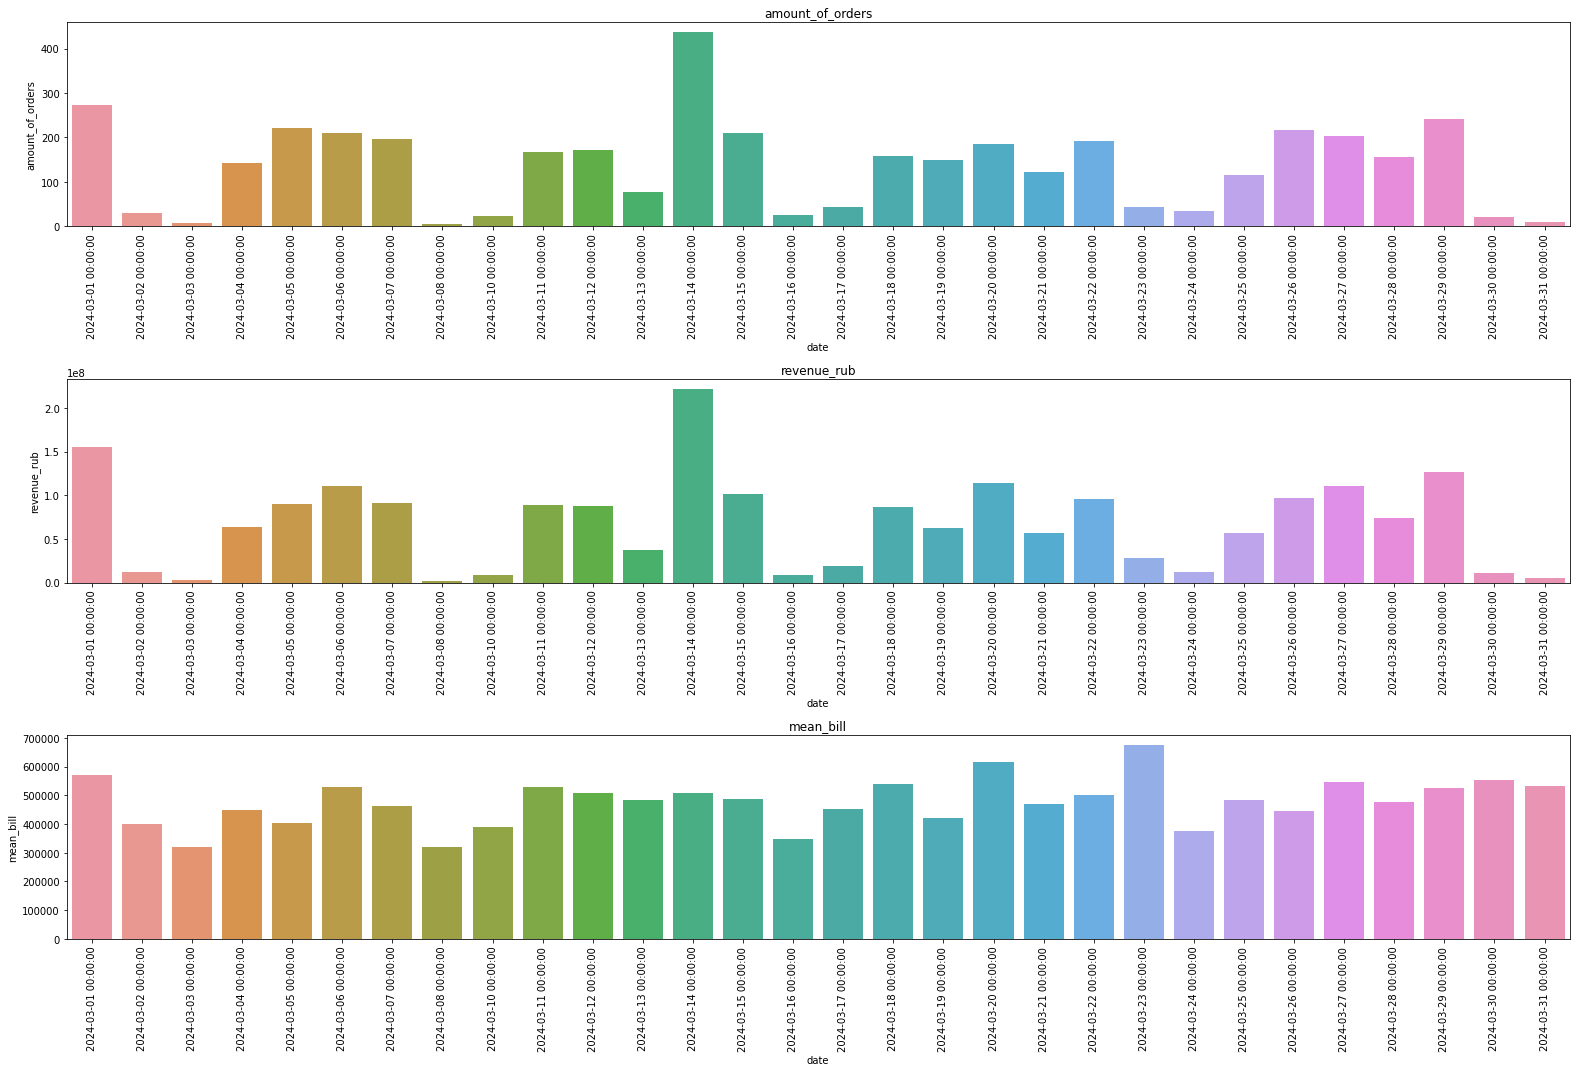

In [45]:
fig, axs = plt.subplots(3, 1, figsize=(22, 15))

plt.tight_layout()

sns.barplot(data=df_stats_metr, x='date', y='amount_of_orders', ax=axs[0])
axs[0].set_xticklabels(df_stats_metr['date'], rotation=90)
axs[0].set_title('amount_of_orders')


sns.barplot(data=df_stats_metr, x='date', y='revenue_rub', ax=axs[1])
axs[1].set_xticklabels(df_stats_metr['date'], rotation=90)
axs[1].set_title('revenue_rub')


sns.barplot(data=df_stats_metr, x='date', y='mean_bill', ax=axs[2])
axs[2].set_xticklabels(df_stats_metr['date'], rotation=90)
axs[2].set_title('mean_bill')


plt.tight_layout()


plt.show()

# sns.barplot(data=df_stats_metr, x='date', y='amount_of_orders')

### Проанализируем интерес клиентов к брендам

## Шаг 15

К вам снова обратился руководитель отдела продаж. Он хочет разобраться, какие бренды востребованы среди клиентов, а какие — нет. На основе данных о названиях товаров в датафрейме `df_full` создайте новую колонку `brand`, где будет только название бренда. **Посчитайте, сколькими брендами интересовались клиенты** (статус заказа здесь не важен, если запись о бренде попала в данные о заказах, значит клиент заказал или хотел заказать товар этого бренда).

In [53]:
def split_col(data):
    return data.split(',')[0]

df_full['brand'] = df_full['name'].apply(split_col)
df_full

,order_id,product_id,quantity,manager,date,client_id,status,id,name,price,category,currency_rate,price_rub,revenue_rub,brand
0,QPLK-54839036,489,11,Владимир Ударников,2024-03-10,52,confirmed,489,"Heco, Ambient 33F",290.74,Настенная акустика,90.7493,26384.451482,2.902290e+05,Heco
1,QPLK-54839036,594,6,Владимир Ударников,2024-03-10,52,confirmed,594,"JBL, Control 28-1",301.85,Настенная акустика,90.7493,27392.676205,1.643561e+05,JBL
2,QPLK-54839036,670,16,Владимир Ударников,2024-03-10,52,confirmed,670,"KEF, LSX Wireless",810.17,Беспроводная акустика,90.7493,73522.360381,1.176358e+06,KEF
3,QPLK-54839036,469,9,Владимир Ударников,2024-03-10,52,confirmed,469,"Heco, Studio Pro 10",82.34,Конденсаторный микрофон,90.7493,7472.297362,6.725068e+04,Heco
4,QPLK-54839036,1302,5,Владимир Ударников,2024-03-10,52,confirmed,1302,"Rode, NT1-A",191.86,Конденсаторный микрофон,90.7493,17411.160698,8.705580e+04,Rode
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4598,YHMP-64962628,564,40,Маргарита Камертонова,2024-03-03,44,confirmed,564,"JBL, Tune 510BT",45.38,Беспроводные наушники,91.3336,4144.718768,1.657888e+05,JBL
4599,YHMP-64962628,486,17,Маргарита Камертонова,2024-03-03,44,confirmed,486,"Heco, Ambient 22F",185.50,Настенная акустика,91.3336,16942.382800,2.880205e+05,Heco
4600,YHMP-64962628,832,28,Маргарита Камертонова,2024-03-03,44,confirmed,832,"LG, SK1",86.56,Саундбар,91.3336,7905.836416,2.213634e+05,LG
4601,YHMP-64962628,254,10,Маргарита Камертонова,2024-03-03,44,confirmed,254,"Edifier, R1280T",86.99,Активные колонки,91.3336,7945.109864,7.945110e+04,Edifier


In [61]:
a = df_full['brand'].nunique()
print(f'Клиенты инетресовались {a} брендами')

Клиенты инетресовались 121 брендами


## Шаг 16

Посчитайте, какую выручку принес каждый бренд и в скольких подтвержденных заказах были товары этого бренда. **Определите, какой бренд принес наибольшую выручку.** В ответ укажите его название.

Дополнительно: проверьте, именно этот бренд встречается в большем количестве заказов, чем другие бренды? Или может его реже заказывают, но на более крупные суммы?

In [83]:
df_conf_brands = df_full.query("status == 'confirmed'") \
    .groupby('brand', as_index=False) \
    .agg({'revenue_rub': 'sum', 'order_id': 'nunique'}) \
    .rename(columns={'order_id': 'amount_of_sales'}) \
    .sort_values('revenue_rub', ascending=False)
df_conf_brands


print(f'Бренд {list(df_conf_brands.head(1).brand)[0]} принес наибольшую выручку')

Бренд JBL принес наибольшую выручку


In [84]:
df_conf_brands

,brand,revenue_rub,amount_of_sales
46,JBL,2.665961e+08,264
43,Heco,2.388163e+08,229
53,Klipsch,2.039024e+08,205
120,Yamaha,1.658651e+08,218
49,KEF,1.465101e+08,73
...,...,...,...
8,AudioSource,3.388167e+04,1
40,Fosi Audio,3.129419e+04,1
1,ART,2.670040e+04,2
18,Bravo Audio,2.405086e+04,1


## Шаг 17

У одних брендов большинство товаров востребовано клиентами, а у других — клиенты заказывают только небольшую часть товаров, а остальные зря занимают виртуальную «полку» в перечне товаров, продаваемых вашей компанией. **Вам нужно определить, какие бренды редко попадают в заказы, хотя товаров таких брендов на самом деле много.**

Начнем с того, что определим, какие товары из имеющихся в продаже хоть раз заказывали, а какие — нет. Для этого соберите список из перечня уникальных идентификаторов товаров, которые встречаются в датафрейме `df_confirmed`. После этого для каждого товара в датафрейме `df_products` определите, был ли этот товар в списке заказанных товаров в этом месяце или нет: создайте новую колонку `is_in_orders` и заполните её соответственно значениями `yes` или `no` для каждого товара.

**В ответе укажите, сколько товаров были заказаны, а сколько — не были**

In [108]:
#определим, какие товары из имеющихся в продаже хоть раз заказывали, а какие — нет. 
products_in_orders = list(df_full.query("status == 'confirmed'").product_id.unique())
products_in_orders


[489,
 594,
 670,
 469,
 1302,
 1309,
 134,
 1659,
 383,
 640,
 1484,
 225,
 1325,
 504,
 513,
 998,
 75,
 707,
 763,
 617,
 1023,
 1189,
 1315,
 1354,
 1367,
 39,
 630,
 452,
 519,
 1637,
 793,
 787,
 1186,
 722,
 643,
 870,
 799,
 550,
 464,
 123,
 778,
 1550,
 11,
 496,
 501,
 665,
 563,
 807,
 484,
 1238,
 517,
 1099,
 625,
 1592,
 628,
 895,
 494,
 614,
 755,
 1364,
 382,
 1591,
 1497,
 1626,
 1247,
 499,
 27,
 1485,
 924,
 578,
 1196,
 575,
 372,
 1271,
 1445,
 669,
 1458,
 1548,
 523,
 1523,
 1382,
 990,
 903,
 1237,
 1263,
 981,
 634,
 1654,
 1652,
 1649,
 64,
 315,
 1607,
 1525,
 1285,
 1621,
 1465,
 791,
 1300,
 422,
 1188,
 642,
 1187,
 649,
 498,
 827,
 228,
 510,
 595,
 38,
 236,
 816,
 1655,
 875,
 307,
 714,
 276,
 579,
 602,
 820,
 1190,
 1001,
 1319,
 798,
 777,
 1264,
 1068,
 525,
 522,
 60,
 865,
 776,
 1469,
 759,
 1416,
 1636,
 477,
 974,
 876,
 988,
 107,
 1276,
 320,
 1373,
 819,
 668,
 23,
 432,
 1213,
 1612,
 1071,
 542,
 79,
 1362,
 977,
 1534,
 197,
 229,
 99

In [115]:
#создадим новую колонку is_in_orders

def is_in_orders(data):
    products_in_orders = list(df_full.query("status == 'confirmed'").product_id.unique())
    return 'yes' if data in products_in_orders else 'no'
    
df_products['is_in_orders'] = df_products['id'].apply(is_in_orders)
df_products

,id,name,price,category,brand,is_in_orders
0,207,"Denon, AVR-S540BT",243.52,AV-ресивер,Denon,yes
1,208,"Denon, AVR-X3700H",1305.52,AV-ресивер,Denon,yes
2,209,"Denon, AVR-X4700H",1620.21,AV-ресивер,Denon,yes
3,210,"Denon, AVR-X6700H",2050.31,AV-ресивер,Denon,yes
4,211,"Denon, AVC-X4700H",1496.81,AV-ресивер,Denon,yes
...,...,...,...,...,...,...
1672,1592,"Yamaha, YH-L700A",425.72,Беспроводные наушники,Yamaha,yes
1673,1593,"Yamaha, HPH-MT8",267.38,Беспроводные наушники,Yamaha,yes
1674,1594,"Yamaha, TW-E5A",170.30,Беспроводные наушники,Yamaha,yes
1675,1595,"Yamaha, YH-E500A",222.75,Беспроводные наушники,Yamaha,yes


In [113]:
df_products.is_in_orders.value_counts()

yes    1180
no      497
Name: is_in_orders, dtype: int64

## Шаг 18

Примерно треть товаров не была заказана ни разу в этом месяце. Посмотрим на эти данные в разрезе по брендам. **Определите, у каких брендов доля ни разу не заказанных товаров была больше половины от всех продаваемых товаров этого бренда.** Но не берите в расчет бренды, которые представлены маленьким числом товаров (меньше 15), они не захламляют виртуальную «полку».

Отметьте бренды, у которых доля ни разу не заказанных товаров была больше половины от всех продаваемых товаров этого бренда: 
- AKG  
- ASUS	
- Dali  
- Emotiva  
- KEF  
- Marantz  
- Onkyo  
- Pioneer  
- Yaqin

In [129]:
all_goods_df = df_products.groupby('brand', as_index=False).agg({'id': 'nunique'}) \
    .rename(columns={'id': 'goods_total_amount'}) \
    .sort_values('goods_total_amount', ascending=False)
all_goods_df

,brand,goods_total_amount
57,JBL,115
144,Yamaha,106
94,Pioneer,103
76,Magnat,92
54,Heco,91
...,...,...
65,Koss,1
62,KaraoKing,1
51,Genelec,1
47,Fifine,1


In [137]:
no_goods_df = df_products.query("is_in_orders == 'no'") \
    .groupby('brand', as_index=False).agg({'is_in_orders': 'count'}) \
    .rename(columns={'is_in_orders': 'goods_no_order'}) \
    .sort_values('goods_no_order', ascending=False)
no_goods_df

no_goods_df = no_goods_df.merge(all_goods_df, on='brand')
no_goods_df

no_goods_df['part_no_order'] = no_goods_df['goods_no_order'] / no_goods_df['goods_total_amount']
no_goods_df

,brand,goods_no_order,goods_total_amount,part_no_order
0,Pioneer,70,103,0.679612
1,KEF,54,82,0.658537
2,Dali,49,67,0.731343
3,Magnat,21,92,0.228261
4,Edifier,20,73,0.273973
...,...,...,...,...
87,MXL,1,2,0.500000
88,Mackie,1,4,0.250000
89,Music Hall,1,1,1.000000
90,Musical Fidelity,1,1,1.000000


In [154]:
unpopular_goods = no_goods_df.query('goods_total_amount >= 15').query('part_no_order > 0.500000')
unpopular_goods.sort_values('part_no_order', ascending=False)

list(unpopular_goods.brand)
bad = (', ').join(list(unpopular_goods.brand))


print(f'Самые непопулярные товары у брендов: {bad[:]}')

Самые непопулярные товары у брендов Pioneer, KEF, Dali, Marantz


### Составим отчет по продажам менеджеров

## Шаг 19

Чтобы компания знала, кого из менеджеров отдела продаж премировать, а с кем провести беседу по итогам месяца, **вас попросили сделать отчет по сделкам каждого менеджера**: сколько он оформил подтвержденных заказов и какую выручку они принесли. Но в абсолютных числах вклад каждого сотрудника может быть непонятен. **Поэтому посчитайте значения в процентах: какой % выручки от общей выручки за месяц приходится на каждого менеджера, и какой % заказов от общего числа заказов.** Посчитайте данные и визуализируйте результат, чтобы принимать решение о поощрении или проведении беседы с менеджерами было удобнее. Выберите верные ответы:

- лучшим менеджером по % выручки стала Маргарита Камертонова  
- лучшим менеджером по % заказов стала Маргарита Камертонова  
- первая пятерка менеджеров по % выручки сильно ушла вперед от всех остальных (явно виден большой разрыв между каждым из первой пятерки и каждым из всех остальных менеджеров)  
- в этом месяце нельзя выделить явную пятерку лидеров по % выручки, которые сильно оторвались от остальных  
- лидер по % заказов реализовал более 16% заказов  
- лидер по % заказов реализовал менее 16% заказов  
- наихудшие показатели у Сергея Контрабасова  
- наихудшие показатели у Аркадия Октавина  
- Антон Скрипкин принес в 3 раза меньше выручки, чем Виктор Тромбонов  
- Антон Скрипкин реализовал почти в 3 раза меньше заказов, чем Анастасия Дудкина

In [164]:
df_full

4083

In [186]:
managers = df_full.query("status == 'confirmed'") \
    .groupby('manager', as_index=False).agg({'order_id': 'nunique', 'revenue_rub': 'sum'}) \
    .rename(columns={'order_id': 'amount_confirmed_orders'})
managers['%revenue'] = managers['revenue_rub'] / managers['revenue_rub'].sum() * 100
managers['%order'] = managers['amount_confirmed_orders'] / managers['amount_confirmed_orders'].sum() * 100
managers = managers.sort_values(['%revenue', '%order'], ascending=[False, False])
managers

,manager,amount_confirmed_orders,revenue_rub,%revenue,%order
9,Маргарита Камертонова,48,3.473886e+08,17.043625,15.533981
4,Виктор Тромбонов,50,3.188999e+08,15.645910,16.181230
8,Максим Барабанов,40,2.401478e+08,11.782164,12.944984
5,Владимир Ударников,31,2.084865e+08,10.228792,10.032362
0,Алексей Саксофонов,27,1.953435e+08,9.583970,8.737864
7,Ксения Балалайкина,27,1.817621e+08,8.917638,8.737864
6,Екатерина Тарелкина,28,1.781576e+08,8.740794,9.061489
10,Надежда Гармошкина,21,1.347836e+08,6.612773,6.796117
1,Анастасия Дудкина,20,1.234504e+08,6.056738,6.472492
2,Антон Скрипкин,7,5.150268e+07,2.526832,2.265372


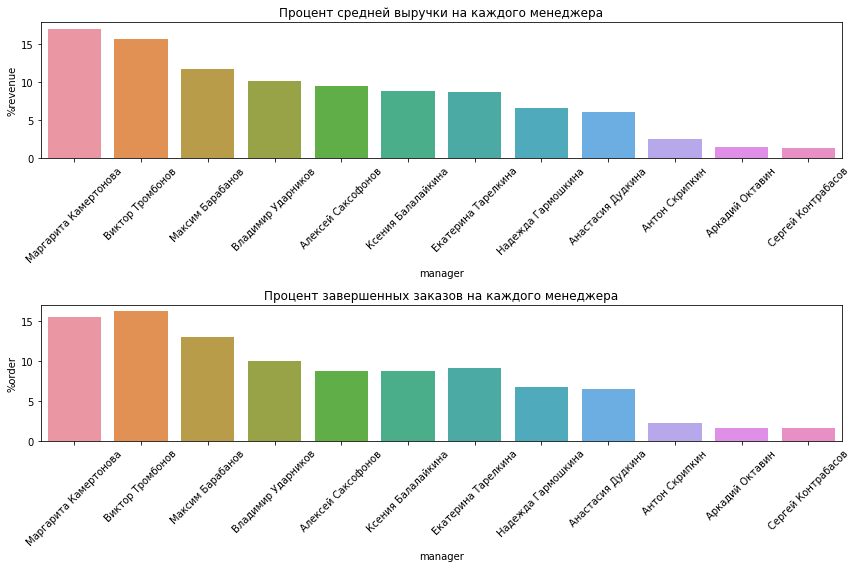

In [188]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

plt.tight_layout()

sns.barplot(x=managers.manager, y=managers['%revenue'], ax=axs[0])
axs[0].set_title('Процент средней выручки на каждого менеджера')
axs[0].set_xticklabels(managers.manager, rotation=45)

sns.barplot(x=managers.manager, y=managers['%order'], ax=axs[1])
axs[1].set_title('Процент завершенных заказов на каждого менеджера')
axs[1].set_xticklabels(managers.manager, rotation=45)

plt.tight_layout()
fig.show()